#### TST Representative Code

This is a representative code for developing and training a full-scale encoder-decoder 'Time-Series-Transformer'. 
Although the architecture is similar to the "Attention is all you need (Vaswani, et. al. 2017) paper, it has to be significantly modified to consider multidimensional float-type time-series sequences instead of one-dimensional textual inputs. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import random

#### How Attention Mechansim Works?

Here is a tensorized description of how attention mechanism works along with the shapes of inputs. The output of the block is what you would get out of nn.Multiheadattention block from pytorch.

In [3]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    def __init__(self, d_model):
        super(Attention, self).__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # Compute query, key, and value tensors
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        # Compute attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1))
        attn_scores = self.softmax(attn_scores)

        # Verify the sum of attention scores
        attn_sum = attn_scores.sum(dim=-1)
        print("Sum of attention scores:", attn_sum)

        # Apply attention weights to values
        attn_output = torch.matmul(attn_scores, v)

        return attn_output, attn_scores


# Example usage
batch_size = 1
seq_length = 12
d_model = 768

# Create a random input tensor
x = torch.randn(batch_size, seq_length, d_model)

# Create an instance of the Attention module
attention = Attention(d_model)

# Pass the input tensor through the attention mechanism
attn_output, attn_scores = attention(x)

# Print the shapes of the output tensors
print("Input shape:", x.shape)
print("Attention output shape:", attn_output.shape)
print("Attention scores shape:", attn_scores.shape)


Sum of attention scores: tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)
Input shape: torch.Size([1, 12, 768])
Attention output shape: torch.Size([1, 12, 768])
Attention scores shape: torch.Size([1, 12, 12])


#### TST Hyperparameters

In [4]:
window_size, prediction_horizon = 12, 6
chunk_size = int(prediction_horizon/2)
input_features, output_features = 6, 4

num_encoder_blocks = 4
num_decoder_blocks = 4
nhead = 8
dim_FFN = 512 # Dimensions of the FFN inside Encoder/Decoder Blocks
dropout = 0.1

d_model = 768 # Vasani (2017)
batch_size = 32

#### Input Embedding
Converting 
$$ X_{RAW} \to X_{EM}  $$
$$ [batch_{size}, W, input_{features}] \to [batch_{size},W,d_{model}] $$

where $d_{model}$ is the internal dimension of the transformer (lifted states), and $W$ is the window size.

Reference: https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html#subsec-cnn-rnn-self-attention


In [5]:
class EmbeddingLayer(nn.Module):
    def __init__(self, input_size, d_model):
        super(EmbeddingLayer, self).__init__()
        self.fc = nn.Linear(input_size, d_model)

    def forward(self, x):
        x = self.fc(x)
        return x


In [6]:
## Example for encoding 
sample = torch.zeros(batch_size, window_size, input_features)
encoder = EmbeddingLayer(input_features, d_model)
encoded_input = encoder(sample)
print('Raw Input [batch_size, window_size, input_features]: \n',sample.shape)
print('------------  CONVERTED TO --------- ')
print('Encoded Input [batch_size, window_size, d_model]: \n',encoded_input.shape)


Raw Input [batch_size, window_size, input_features]: 
 torch.Size([32, 12, 6])
------------  CONVERTED TO --------- 
Encoded Input [batch_size, window_size, d_model]: 
 torch.Size([32, 12, 768])


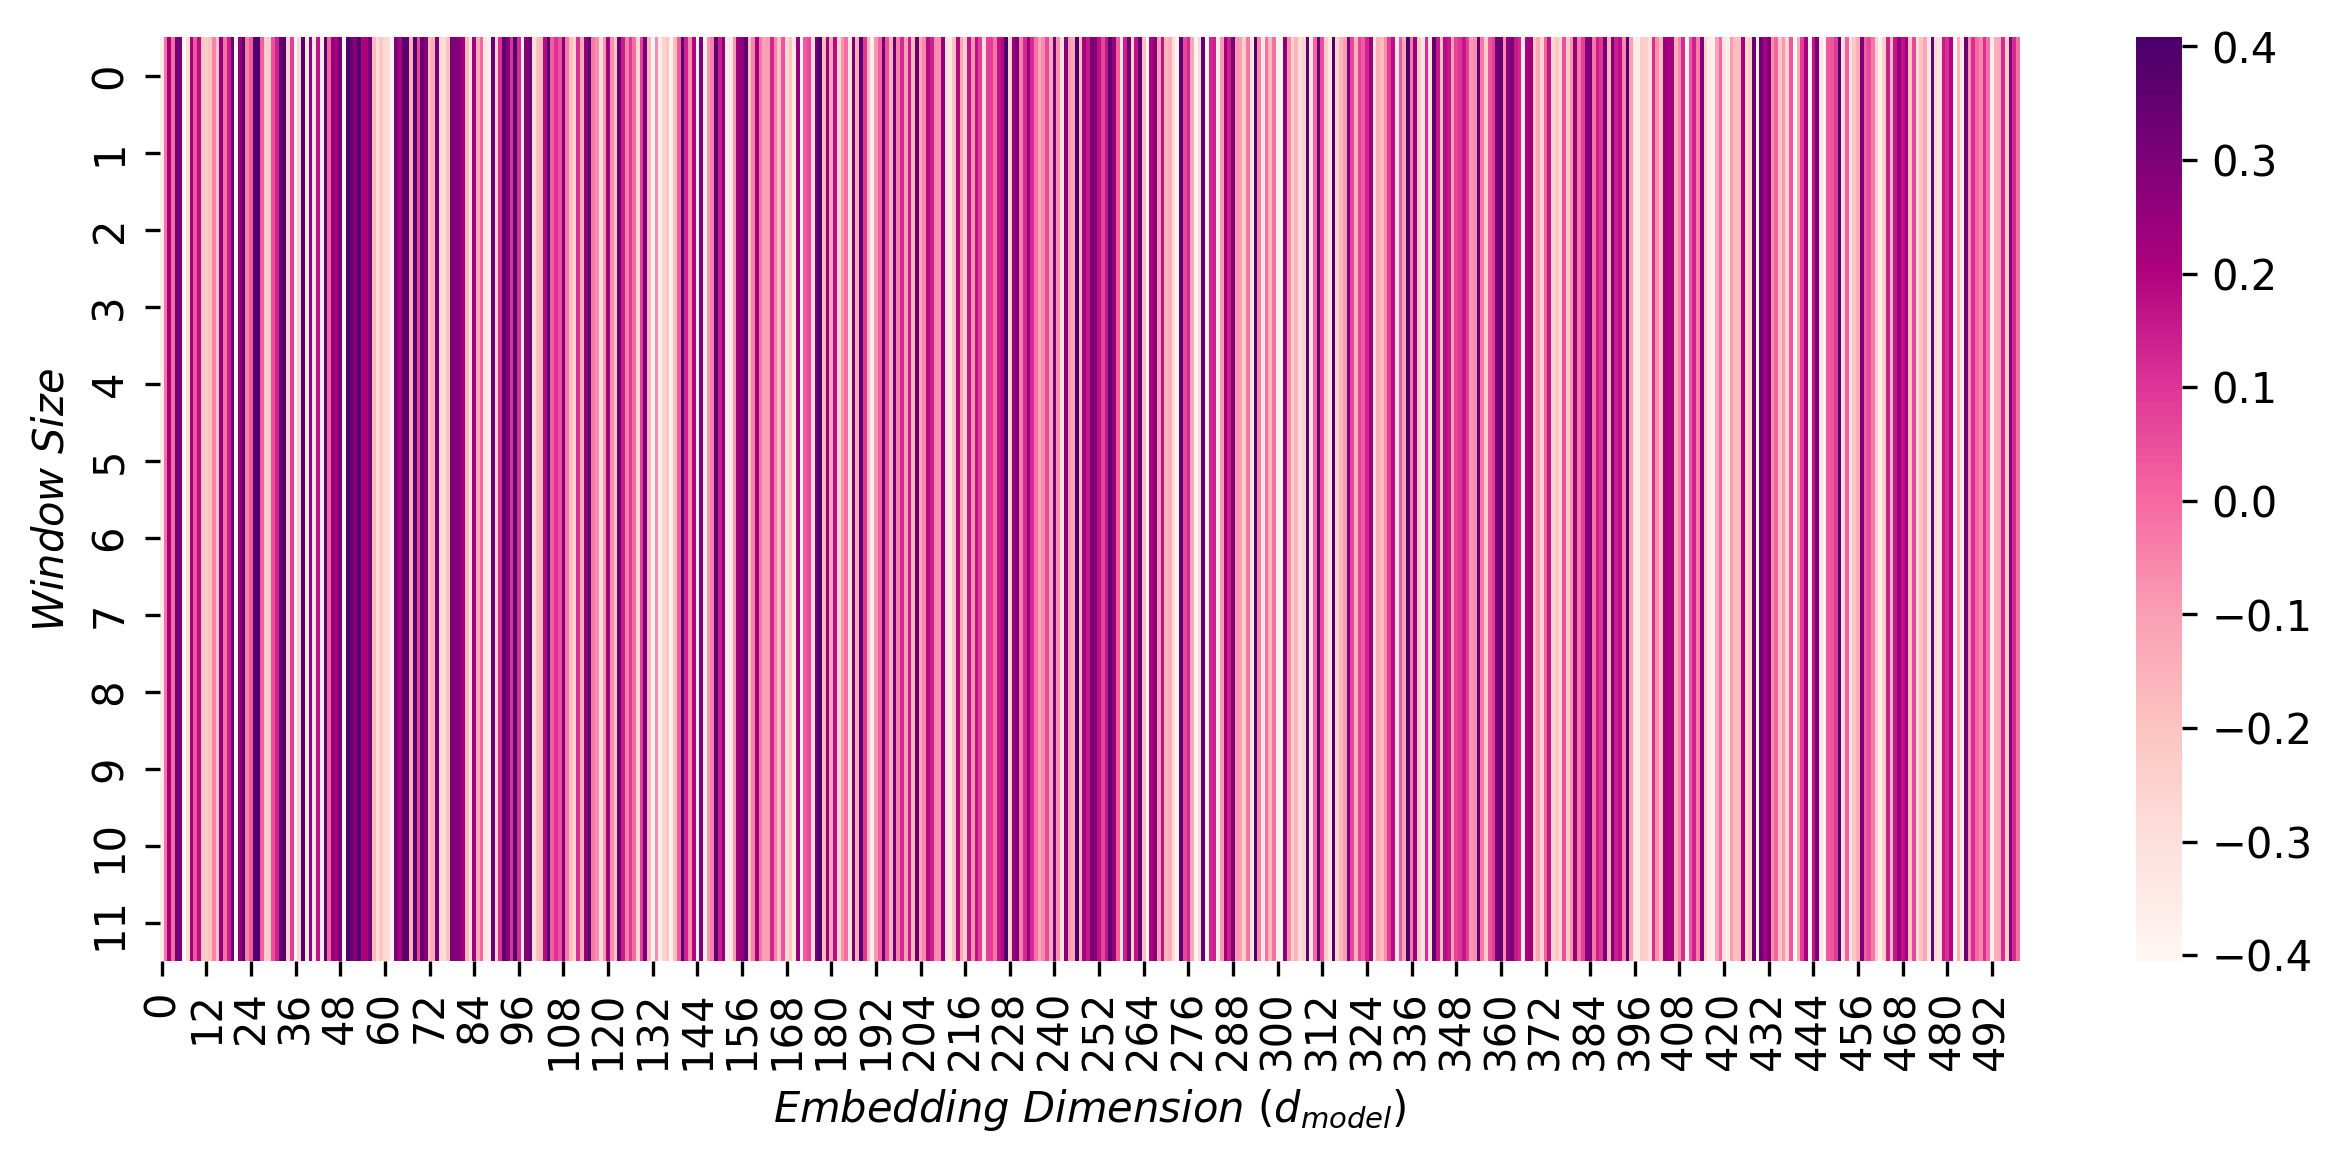

In [7]:
# Create a heatmap of the pos_encoded_input tensor
plt.figure(figsize=(10,4), dpi=300)
sns.heatmap(encoded_input[0,:,:500].detach().numpy(), cmap='RdPu')
# plt.xlabel('$Input~Features~(F_{in})$')
plt.xlabel('$Embedding~Dimension~(d_{model})$')
plt.ylabel('$Window~Size$')
# plt.title('Heat Map for Positional Encoding')
plt.show()

#### Positional Encoding
Converting
$$ X_{EM} \to X_{PE}  $$
$$ [batch_{size}, W, d_{model}] \to [batch_{size},W,d_{model}] $$

In [8]:
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, d_model, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, d_model))
        position = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) 
        div_term = torch.pow(10000, torch.arange(0, d_model, 2, dtype=torch.float32) / d_model)
        X = position/div_term

        # X = torch.arange(max_len, dtype=torch.float32).reshape(
        #     -1, 1) / torch.pow(10000, torch.arange(
        #     0, d_model, 2, dtype=torch.float32) / d_model)
        
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [9]:
pos_encoder = PositionalEncoding(d_model,0, max_len=window_size)
pos_encoded_input = pos_encoder(encoded_input)
print('Encoded Input [batch_size, window_size, d_model]: \n',encoded_input.shape)
print('------------  CONVERTED TO --------- ')
print('PE Input: [batch_size, window_size, d_model]:\n', pos_encoded_input.shape)

Encoded Input [batch_size, window_size, d_model]: 
 torch.Size([32, 12, 768])
------------  CONVERTED TO --------- 
PE Input: [batch_size, window_size, d_model]:
 torch.Size([32, 12, 768])


Visual representation of positional encoding of different features

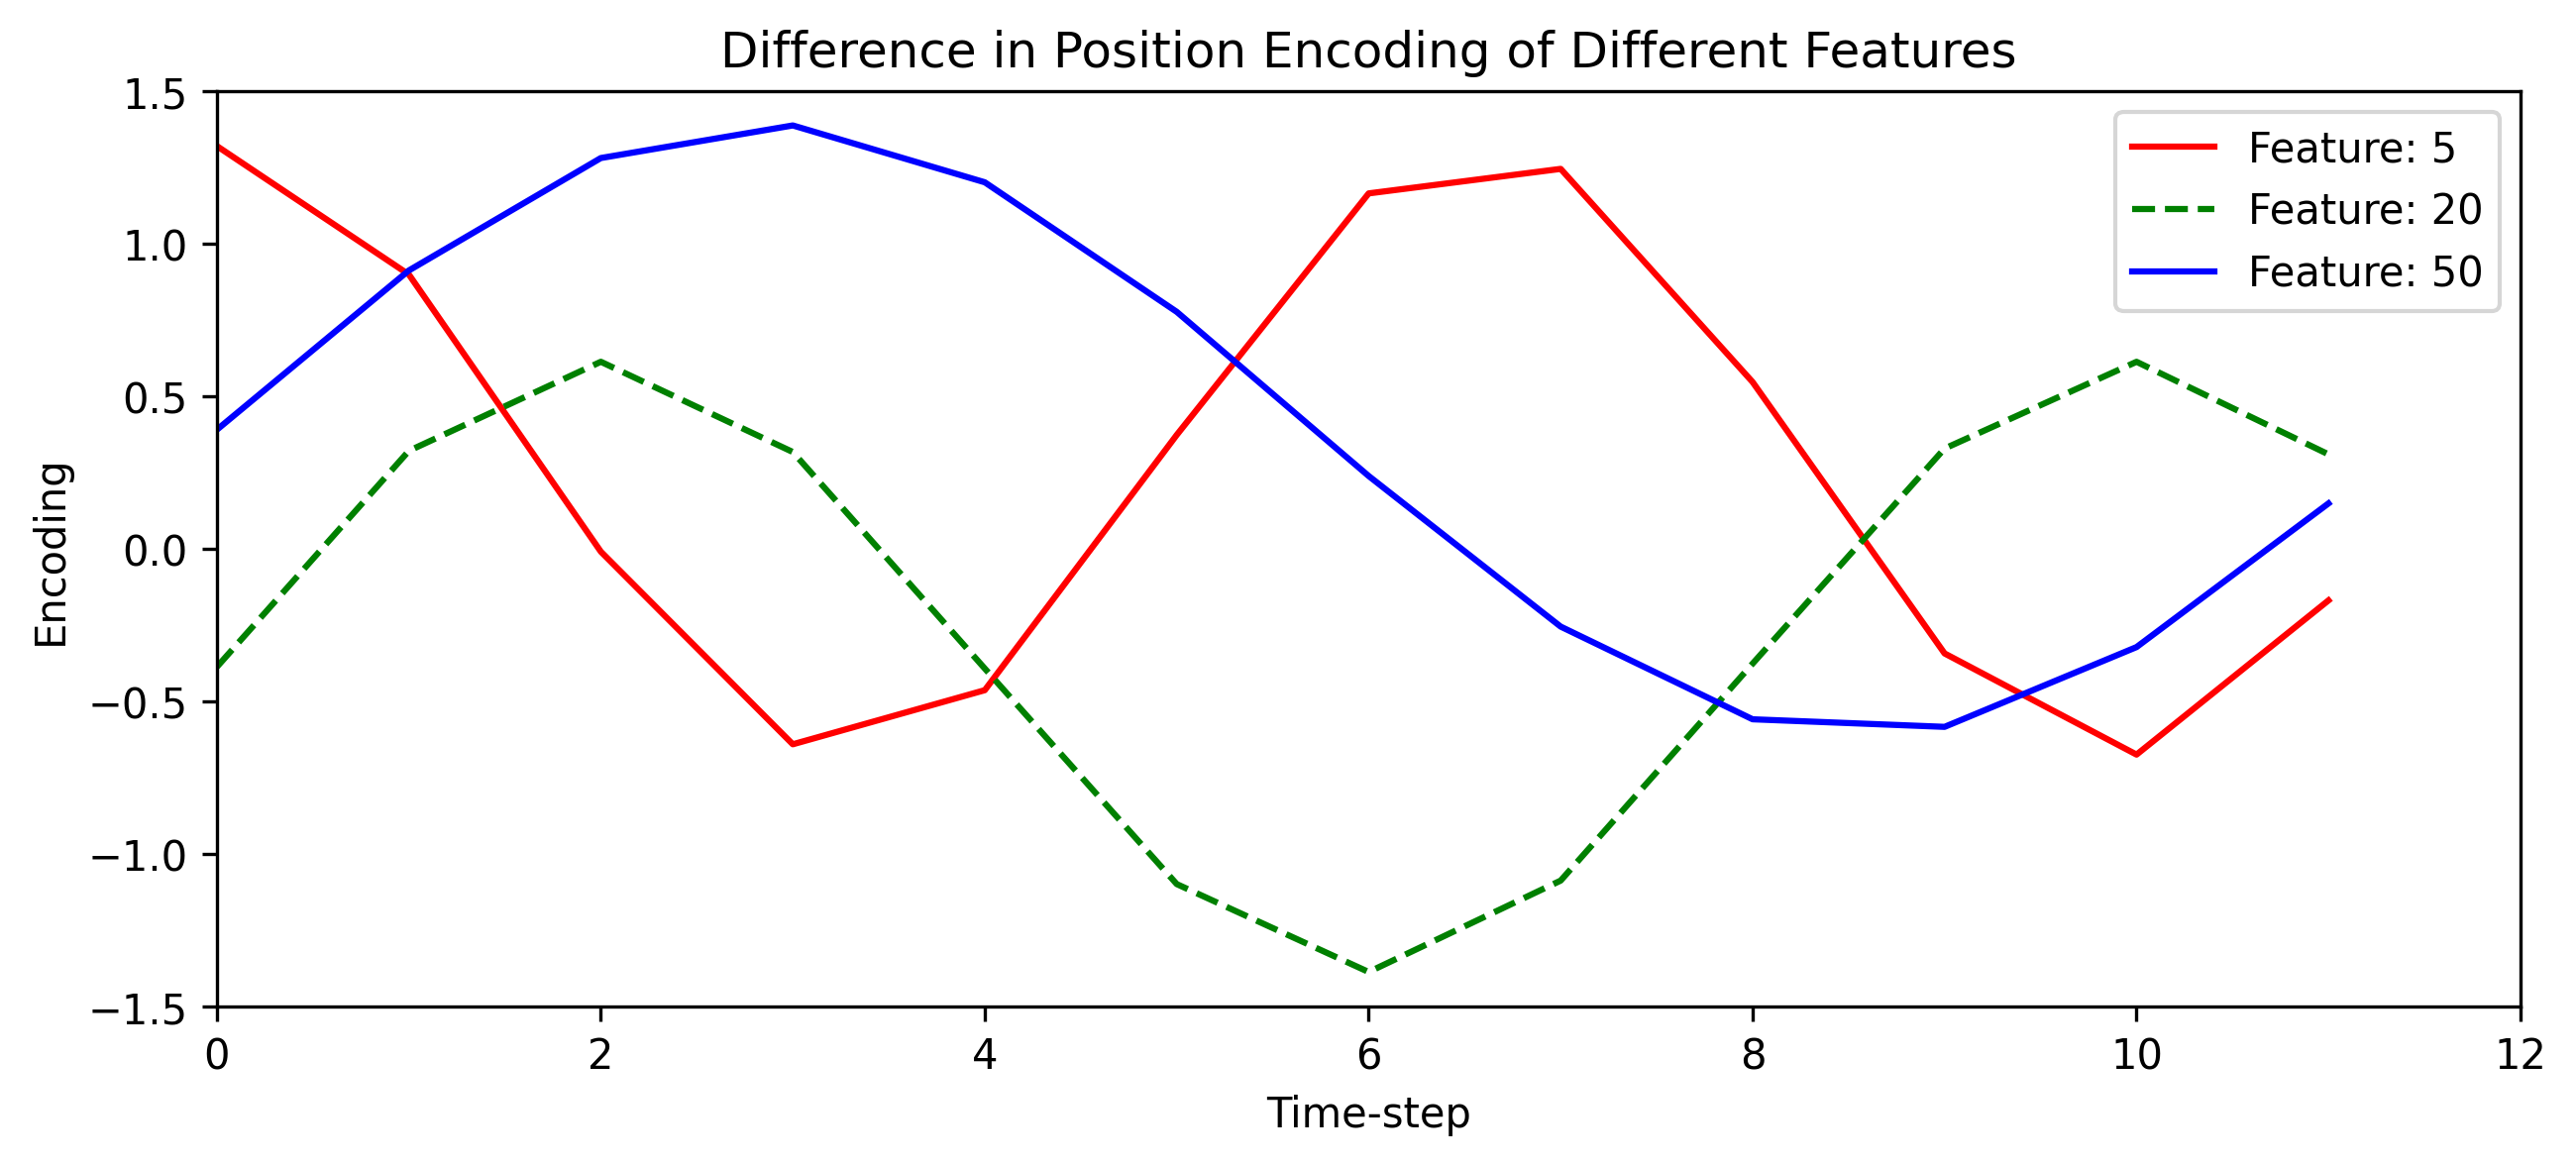

In [27]:
# Define the colors and linestyles for each line
colors = ['red', 'green', 'blue']
linestyles = ['-', '--', '-']

# Plot each line with a different color and linestyle
plt.figure(figsize=(10,4), dpi=300)
for i, color, linestyle in zip([5, 20, 50], colors, linestyles):
    plt.plot(torch.arange(window_size), pos_encoded_input[0, :, i].detach(), color=color, linestyle=linestyle, label=f'Feature: {i}')
plt.legend()
# Set the x-axis and y-axis limits
plt.xlim(0, window_size)
plt.ylim([-1.5,1.5])
plt.title('Difference in Position Encoding of Different Features')
plt.ylabel('Encoding')
plt.xlabel('Time-step')
plt.show()

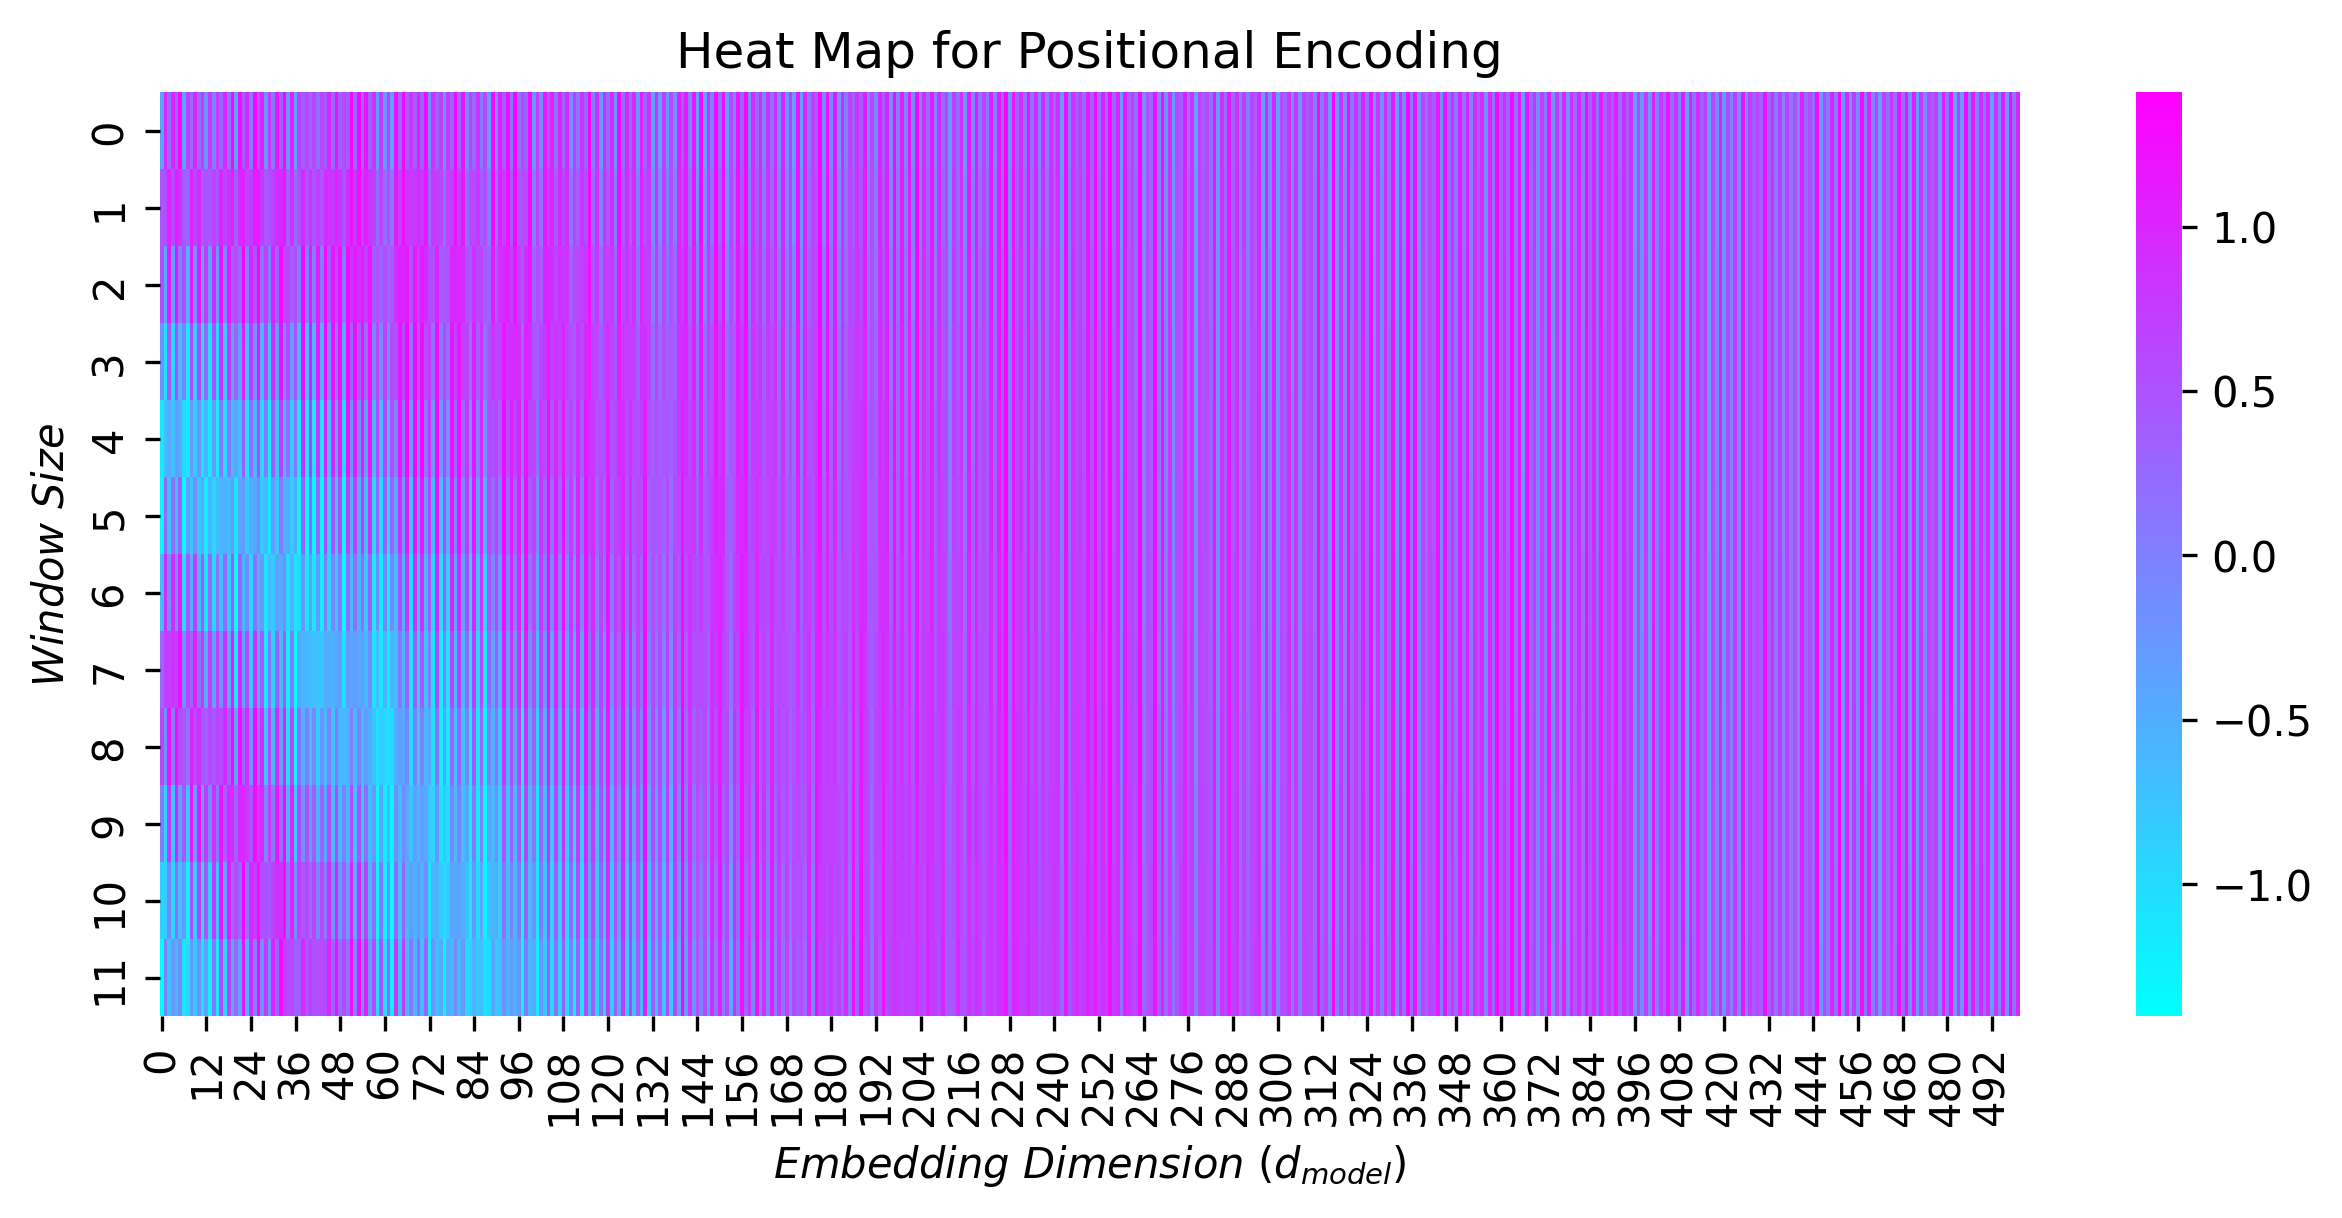

In [11]:
# Create a heatmap of the pos_encoded_input tensor
plt.figure(figsize=(10,4), dpi=300)
sns.heatmap(pos_encoded_input[0,:,:500].detach().numpy(), cmap='cool')
plt.xlabel('$Embedding~Dimension~(d_{model})$')
plt.ylabel('$Window~Size$')
plt.title('Heat Map for Positional Encoding')
plt.show()

#### Encoder Block
1. $\textbf{General Instructions:}$

Converting
$$ X_{PE} \to X_{EN_i}~~[for~i = 1]$$

$$ X_{EN_{i-1}} \to X_{EN_i}~~[for~i \neq 1] $$

Dimensions: 
$$ [batch_{size}, W, d_{model}] \to [batch_{size},W,d_{model}] $$
where $i$ is the $i^{th}$ encoder block.


<br> <br>

2. $\textbf{Layernorm:}$
LayerNorm ($d_{model}$) normalizes the input $[batch_{size},W,d_{model}]$ in the $d_{model}$ dimension to give out an output of the same dimensions $[batch_{size},W,d_{model}]$. 
<br> <br>

3. $\textbf{Output of `N' Encoder Blocks:}$

Any layer in the Transformer encoder does not change the shape of the input vectors.
The positionally encoded input has the dimensions $[batch_{size},W,d_{model}]$, and the output from all the encoded blocks has the dimension $[batch_{size},W,d_{model}]$.  

In [12]:
class TransformerEncoderBlock(nn.Module):  #@save
    """The Transformer encoder block."""
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout,batch_first=True)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(p=dropout)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)


    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x, _ = self.self_attn(x, x, x)
        x = self.dropout1(x)
        x = residual + x
        
        residual = x
        x = self.norm2(x)
        x = self.feedforward(x)
        x = self.dropout2(x)
        x = residual + x
        return x


In [13]:
encoder_block = TransformerEncoderBlock(d_model,nhead=nhead,dim_feedforward=dim_FFN,dropout=dropout)
output = encoder_block(pos_encoded_input)
print('Encoder Output [batch_size, window_size, d_model]:\n',output.shape)

Encoder Output [batch_size, window_size, d_model]:
 torch.Size([32, 12, 768])


Visualize the 'transformation' on the 'positonally encoded input' after an 'Encoder Block'

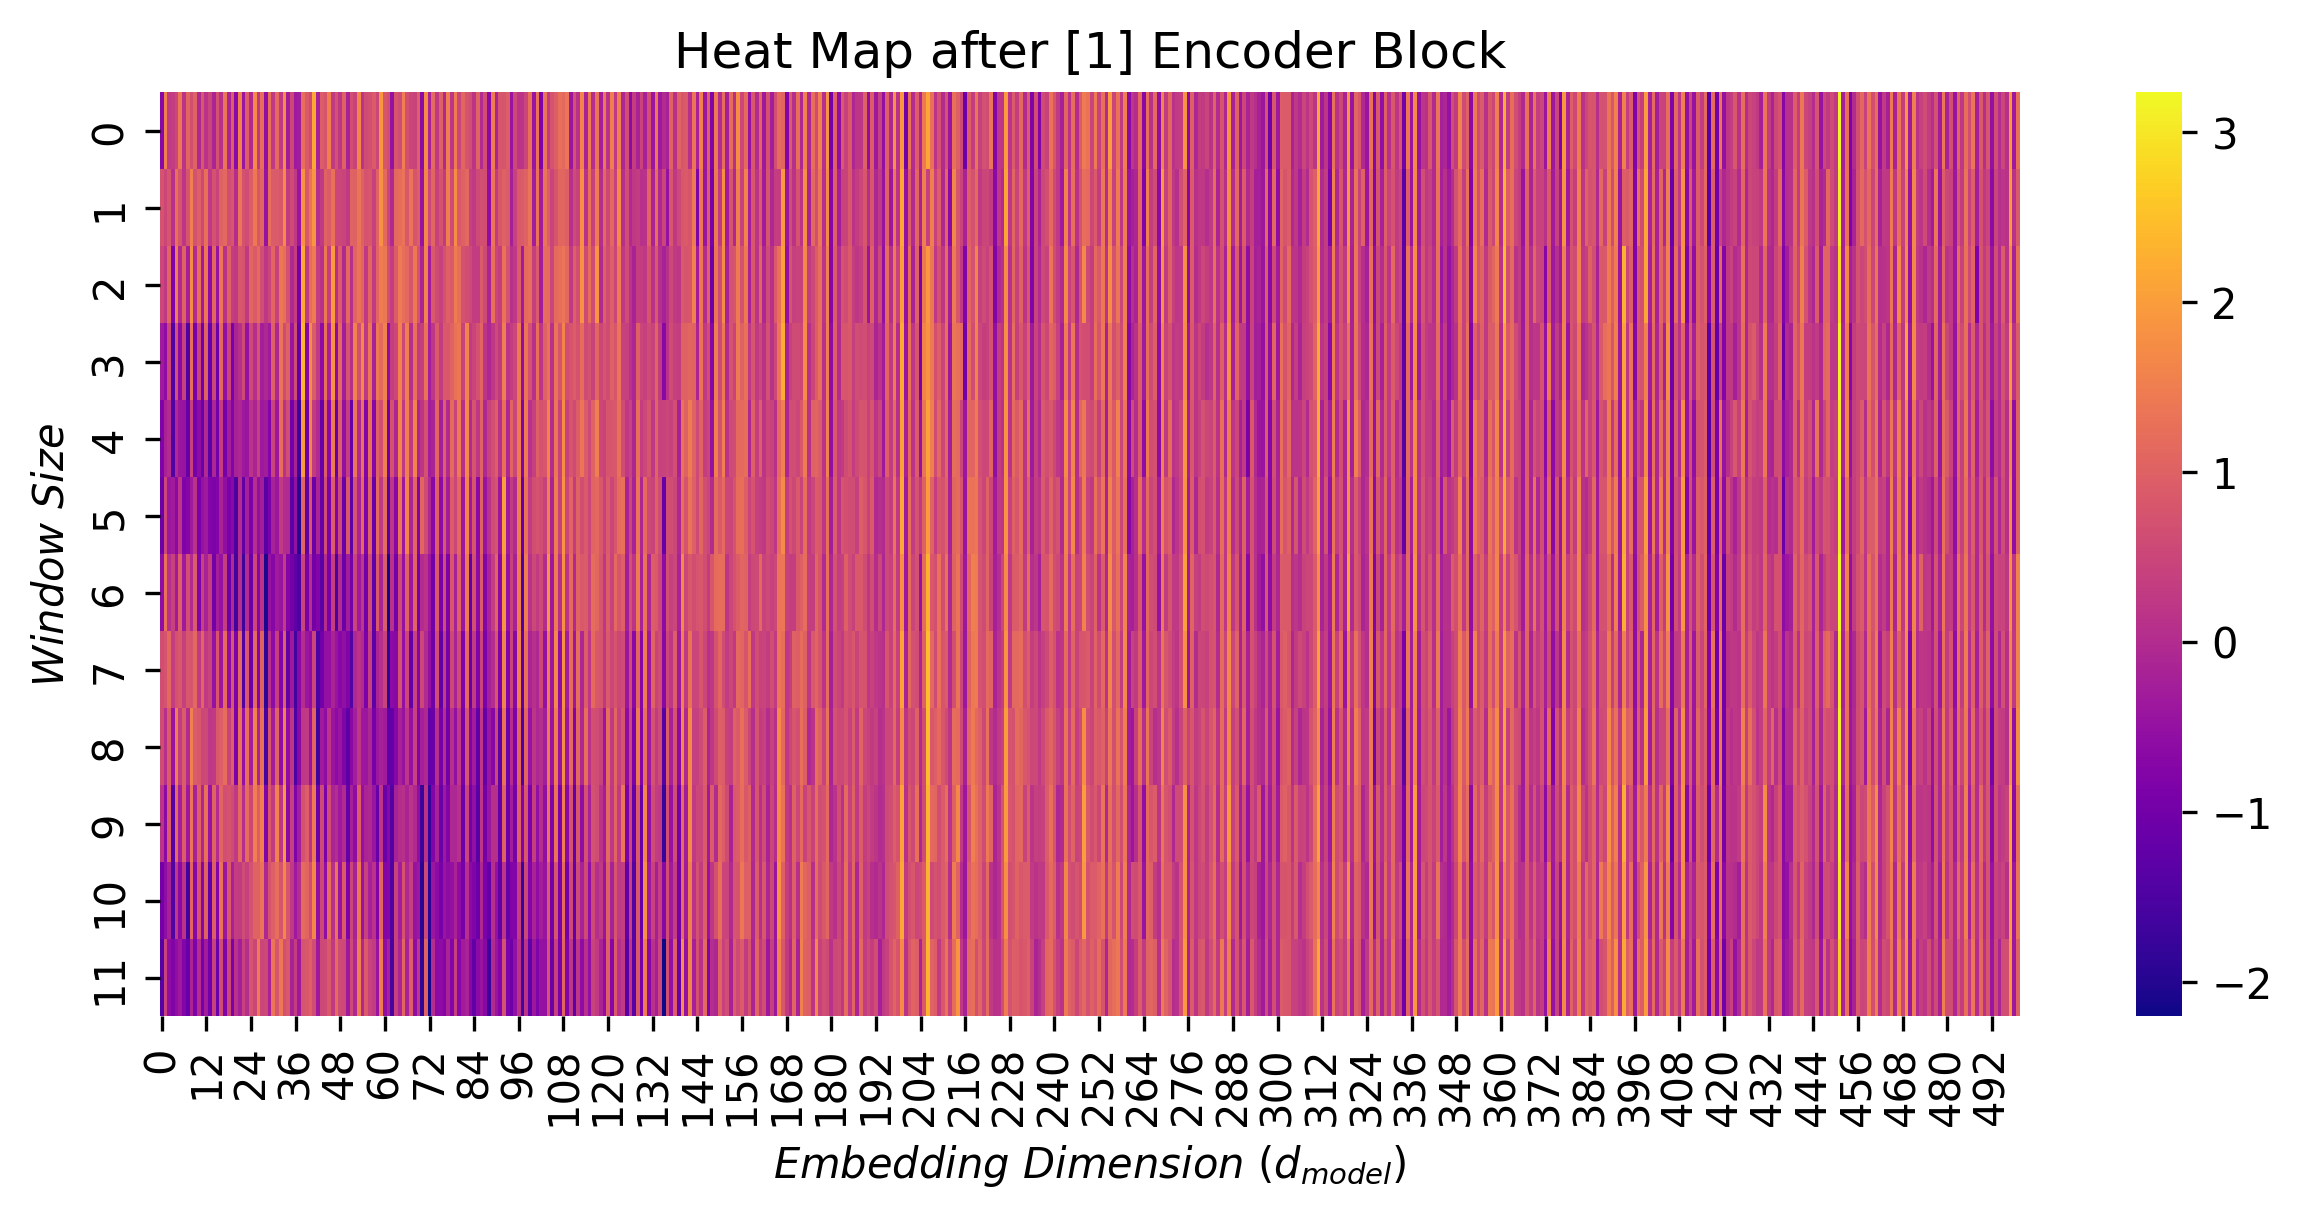

In [14]:
# Create a heatmap of the pos_encoded_input tensor
plt.figure(figsize=(10,4), dpi=300)
sns.heatmap(output[0,:,:500].detach().numpy(), cmap='plasma')
plt.xlabel('$Embedding~Dimension~(d_{model})$')
plt.ylabel('$Window~Size$')
plt.title('Heat Map after [1] Encoder Block')
plt.show()

Stacking Multiple Encoder Blocks

In [15]:
class Multiple_Encoders(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, dim_feedforward, num_encoder_blocks, w, h, dropout):
        super(Multiple_Encoders, self).__init__()

        self.w = w
        self.h = h
        
        self.encoder_blocks = nn.ModuleList([TransformerEncoderBlock(d_model, nhead, dim_feedforward,dropout=dropout) for _ in range(num_encoder_blocks)])

        self.encoder_linear = EmbeddingLayer(input_size, d_model)

        self.pos_encoder = PositionalEncoding(d_model,max_len = self.w,dropout=dropout)

    def forward(self, x):
        x = self.encoder_linear(x)  # Pass through the encoder linear layer
        x = self.pos_encoder(x)  # Add positional encoding
        for block in self.encoder_blocks:
            x = block(x)  # Pass through the encoder TSTBlock modules
        return x


Visualizing Output from Multiple Encoded Blocks

Shape after Multiple Encoder Blocks: torch.Size([32, 12, 768])


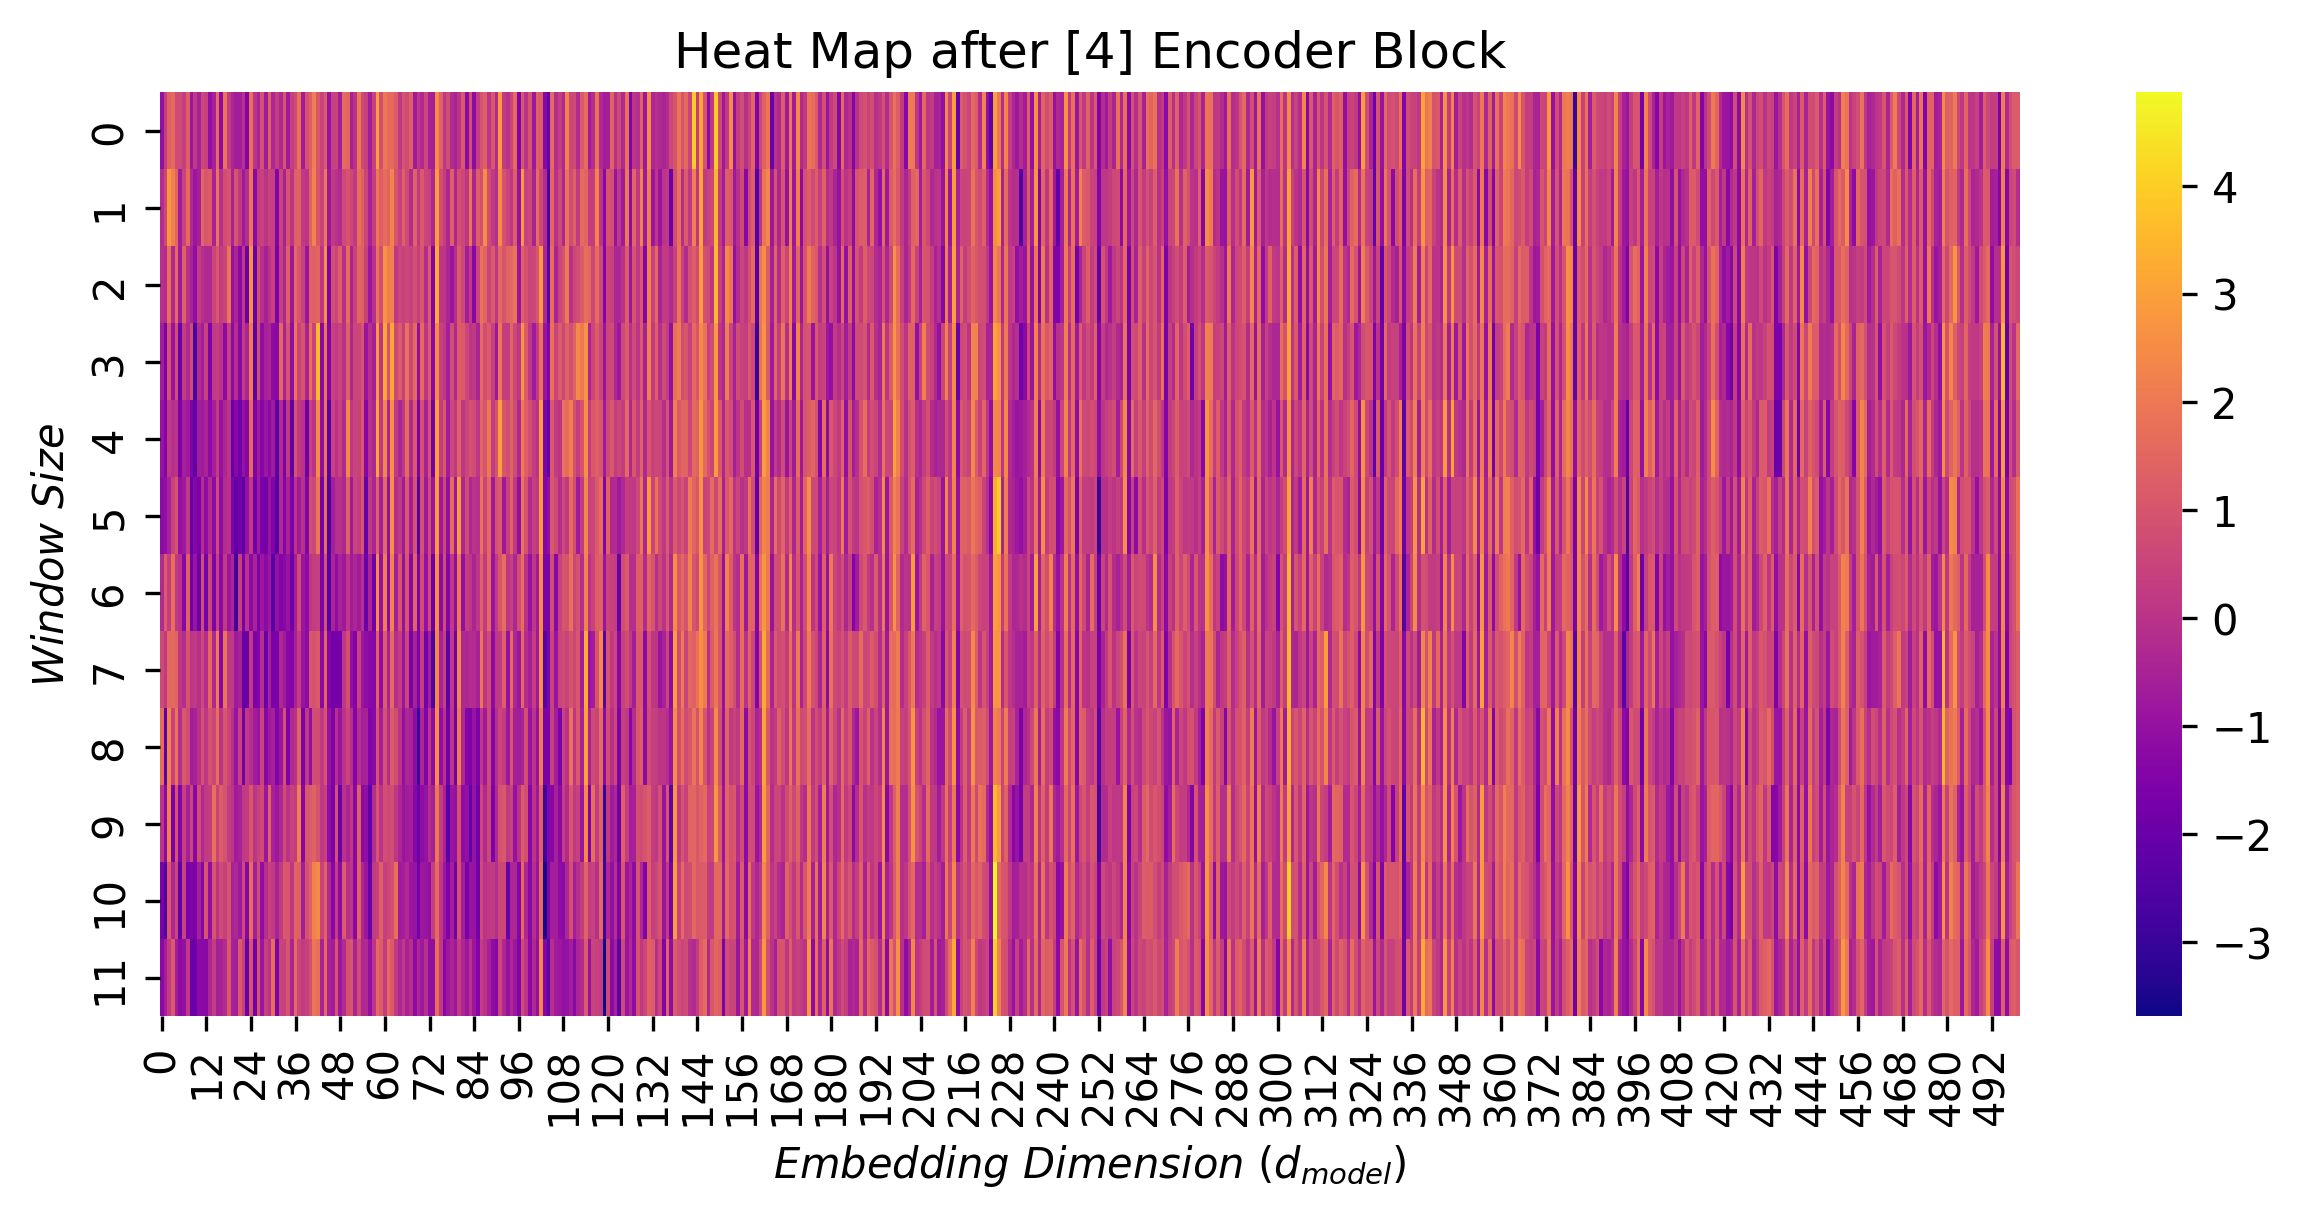

In [16]:
multiple_encoder_blocks = Multiple_Encoders(input_size=input_features,output_size=output_features,
                                   d_model=d_model,nhead=nhead,dim_feedforward=dim_FFN
                                   ,num_encoder_blocks=num_encoder_blocks, 
                                   w=window_size,h=prediction_horizon,
                                   dropout=dropout)

encoder_output = multiple_encoder_blocks(sample)
print('Shape after Multiple Encoder Blocks:', encoder_output.shape)

# Create a heatmap of the pos_encoded_input tensor
plt.figure(figsize=(10,4), dpi=300)
sns.heatmap(encoder_output[0,:,:500].detach().numpy(), cmap='plasma')
plt.xlabel('$Embedding~Dimension~(d_{model})$')
plt.ylabel('$Window~Size$')
plt.title('Heat Map after [' + str(num_encoder_blocks) + '] Encoder Block')
plt.show()

#### Decoder Block
1. $\textbf{General Instructions:}$

Converting

$$ X_{EN_{i}} \to X_{DEC_1}~~[for~i=1]$$
$$ X_{DEC_{i-1}} \to X_{DEC_{i}}~~[for~i\neq1]$$

Dimensions: 
$$ [batch_{size}, W, d_{model}] \to [batch_{size},H+\lambda,d_{model}] $$
where $W$ is the window size (used in the encoder side of things), and $H$ is the prediciton horizon (used in the decoder side of things).


<br> <br>

2. $\textbf{Decoder Linear Layer and Positional Encoding}$

The decoder embedding layer takes in the input ($y_{raw}$) that has dimensions $[batch_{size},H,F_{out}] $, and converts it to $[batch_{size},H,d_model]$ represented by $Y_{EM}$
The positional encoder for the decoder side uses positional encoding with *max_len = (H+chunk_size)* to convert it to $Y_{PE}$. 

3. $\textbf{Output of `M' Decoder Blocks:}$

The decoder takes in  ($y_{raw}$) of size  $[batch_{size},H,F_{out}]$ and converts it to a decoder output of size $[batch_{size},H,d_{model}]$.

4. $\textbf{Note:}$

The internal dimension of the transformer ($d_{model}$) should be the same for the encoder and decoder side. However, on encoder side the 'seq_len' is $W$, and on the decoder side it is $H$.*

In [17]:
class TransformerDecoderBlock(nn.Module):  #@save
    """The Transformer Decoder Block."""
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout,batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout,batch_first=True)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(p=dropout)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)
        self.dropout3 = nn.Dropout(p=dropout)


    def forward(self, x, memory):
        residual = x
        x = self.norm1(x)
        x, _ = self.self_attn(x, x, x)
        x = self.dropout1(x)
        x = residual + x

        residual = x
        x = self.norm2(x)
        x, cross_attn_weights  = self.cross_attn(x, memory, memory)
        x = self.dropout2(x)
        x = residual + x
        
        residual = x
        x = self.norm3(x)
        x = self.feedforward(x)
        x = self.dropout3(x)
        x = residual + x
        return x, cross_attn_weights
    


Decoder Output [batch_size, prediction_horizon, d_model]:
 torch.Size([32, 6, 768])


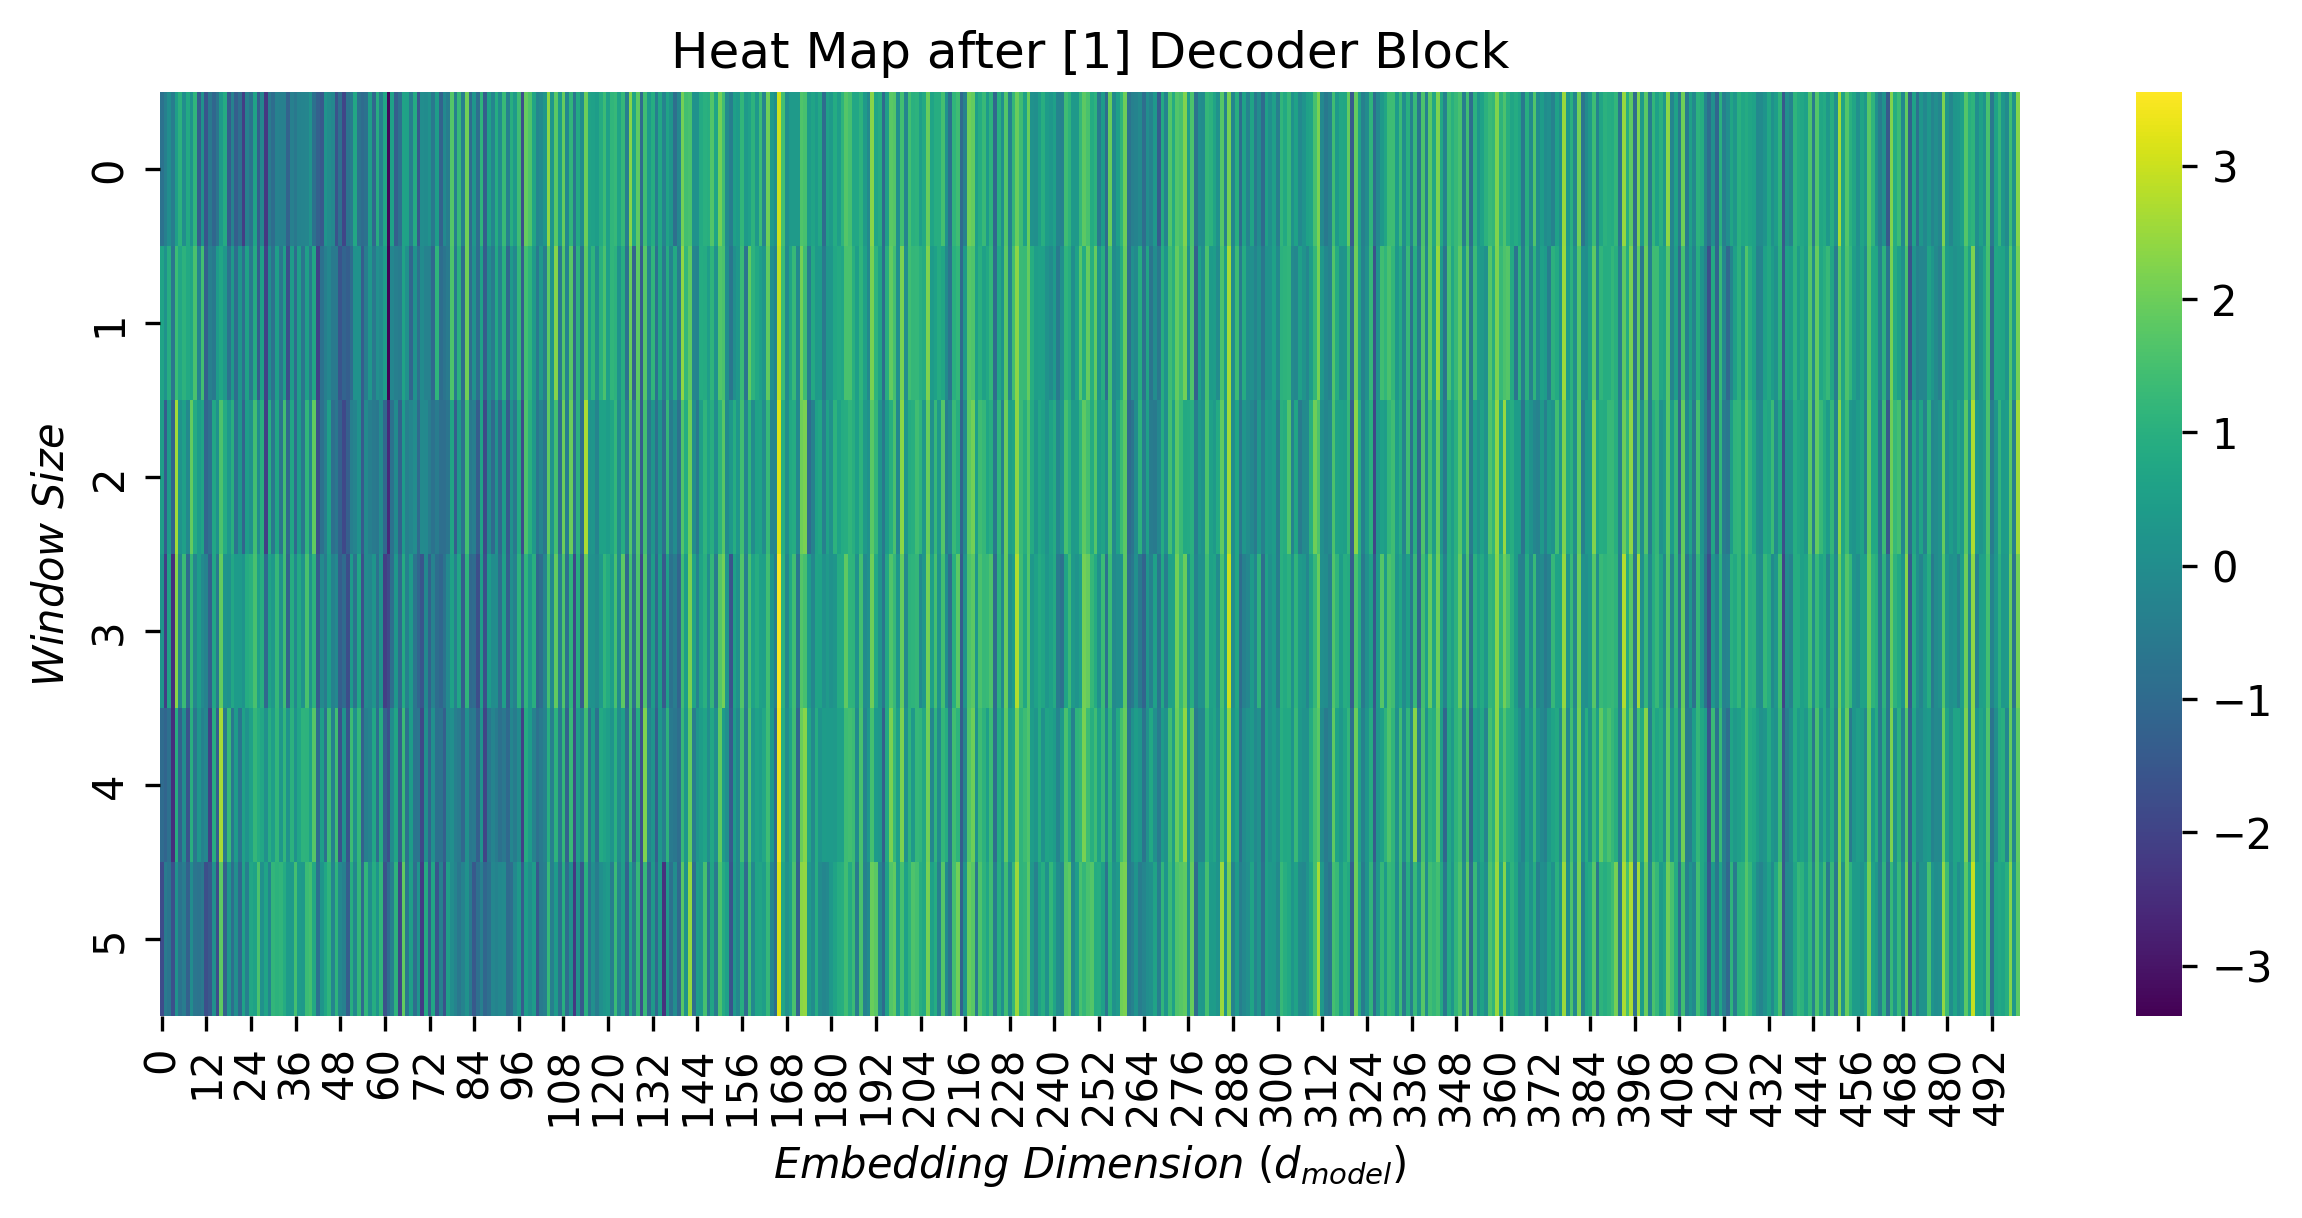

In [18]:
sample_decoder = torch.zeros(batch_size, prediction_horizon, d_model)
decoder_block= TransformerDecoderBlock(d_model,nhead=nhead,dim_feedforward=dim_FFN,dropout=dropout)
# decoded_output = decoder_block(output[:,-prediction_horizon:,:],sample_decoder)

decoded_output, cross_attn_weights = decoder_block(output[:,-prediction_horizon:,:],output[:,-prediction_horizon:,:])
print('Decoder Output [batch_size, prediction_horizon, d_model]:\n',decoded_output.shape)

# Create a heatmap
plt.figure(figsize=(10,4), dpi=300)
sns.heatmap(decoded_output[0,:,:500].detach().numpy(), cmap='viridis')
plt.xlabel('$Embedding~Dimension~(d_{model})$')
plt.ylabel('$Window~Size$')
plt.title('Heat Map after [1] Decoder Block')
plt.show()


Stacking Multiple Decoder Blocks

In [19]:
class Multiple_Decoders(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, dim_feedforward, num_decoder_blocks, w, h, chunk_size, dropout):
        super(Multiple_Decoders, self).__init__()

        self.w = w
        self.h = h
        
        self.decoder_blocks = nn.ModuleList([TransformerDecoderBlock(d_model, nhead, dim_feedforward,dropout=dropout) for _ in range(num_decoder_blocks)])
        self.cross_attn_weights = []  # List to store cross-attention weights

        self.decoder_linear = EmbeddingLayer(output_size, d_model)

        self.pos_decoder = PositionalEncoding(d_model,max_len = self.h + chunk_size,dropout=dropout)

    def forward(self, x, memory):
        x = self.decoder_linear(x)  # Pass through the encoder linear layer
        x = self.pos_decoder(x)  # Add positional encoding
        for block in self.decoder_blocks:
            x, cross_attn_weights = block(x, memory)  # Pass through the decoder TSTBlock modules
            self.cross_attn_weights.append(cross_attn_weights)  # Save the cross-attention weights
        return x


Visualizing output from just the decoder:

First we need to take $X_{RAW}$ and then run it through the encoder blocks, and then combine $y_{RAW}$ for the cross-attention. 

Shape after Multiple Encoder Blocks: torch.Size([32, 12, 768])


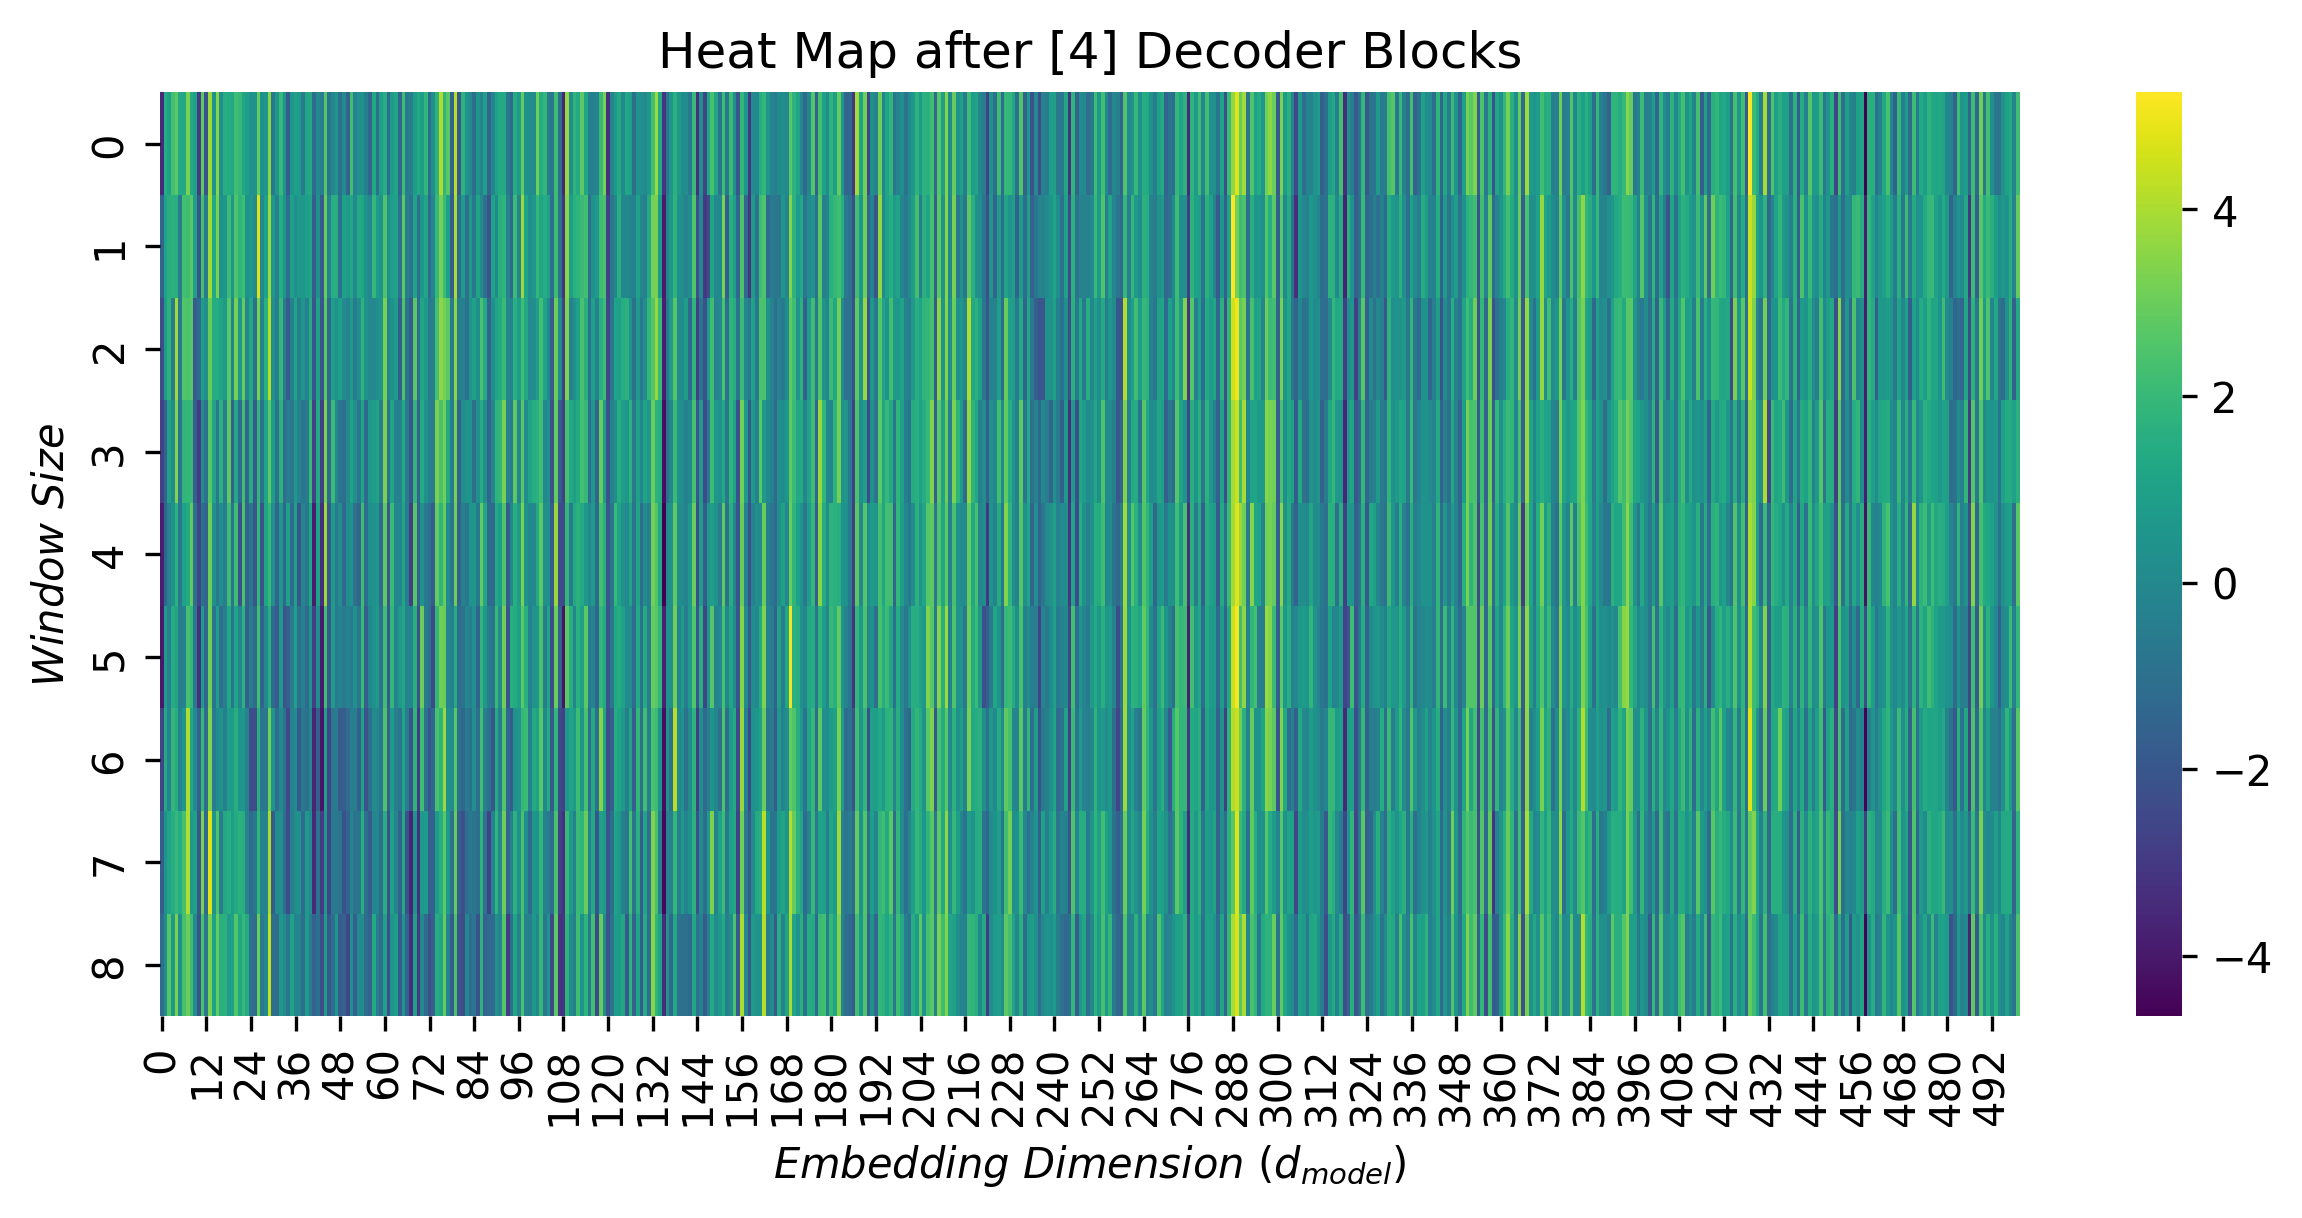

In [20]:
sample_decoder = torch.zeros(batch_size, chunk_size+prediction_horizon, output_features)

multiple_encoder_blocks = Multiple_Encoders(input_size=input_features,output_size=output_features,
                                   d_model=d_model,nhead=nhead,dim_feedforward=dim_FFN
                                   ,num_encoder_blocks=num_encoder_blocks, 
                                   w=window_size,h=prediction_horizon,
                                   dropout=dropout)

encoder_output = multiple_encoder_blocks(sample)
print('Shape after Multiple Encoder Blocks:', encoder_output.shape)

multiple_decoder_blocks = Multiple_Decoders(input_size=input_features, output_size=output_features, 
                                            d_model=d_model,nhead=nhead,dim_feedforward=dim_FFN,
                                            num_decoder_blocks=num_decoder_blocks,
                                            w=window_size,h=prediction_horizon, chunk_size=chunk_size,
                                            dropout=dropout)

decoder_output = multiple_decoder_blocks(sample_decoder,encoder_output[:,-(chunk_size+prediction_horizon):,:])
attention_weights = multiple_decoder_blocks.cross_attn_weights

# Create a heatmap of the pos_encoded_input tensor
plt.figure(figsize=(10,4), dpi=300)
sns.heatmap(decoder_output[0,:,:500].detach().numpy(), cmap='viridis')
plt.xlabel('$Embedding~Dimension~(d_{model})$')
plt.ylabel('$Window~Size$')
plt.title('Heat Map after [' + str(num_decoder_blocks) + '] Decoder Blocks')
plt.show()

Visualizing attention weights from multiple decoders

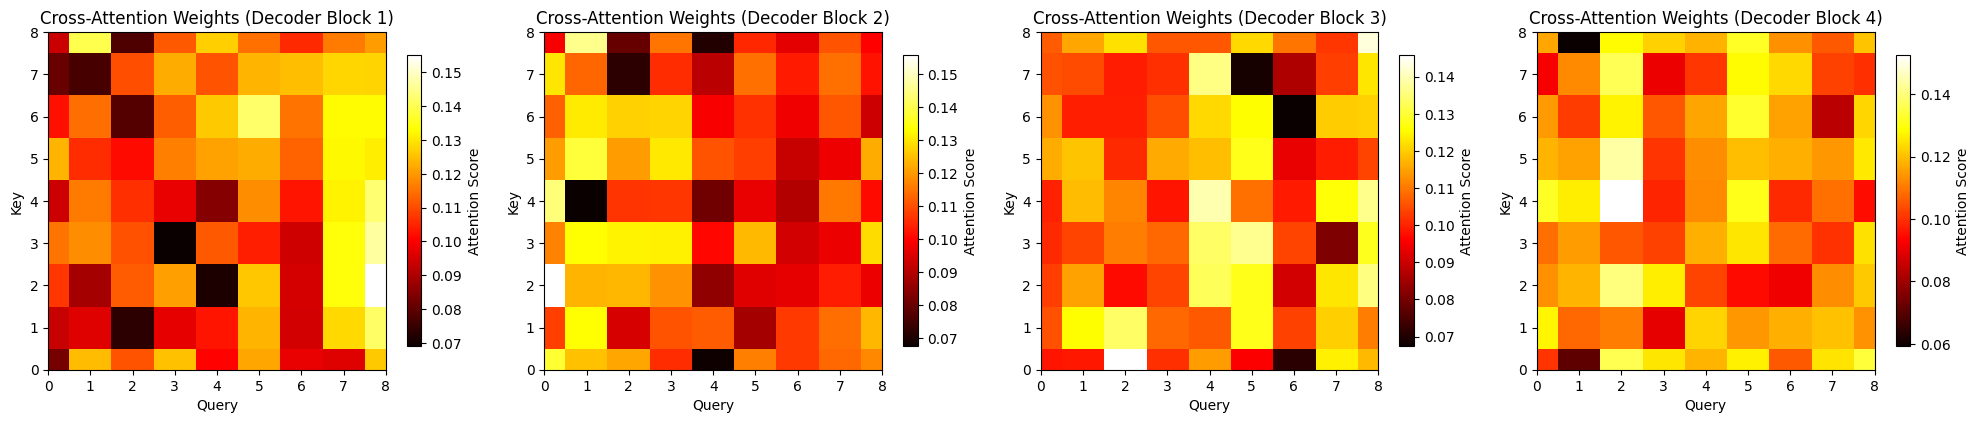

In [21]:
batch_index = random.randint(0, batch_size - 1) 
num_blocks = len(attention_weights)

# Create a single figure with subplots
fig, axes = plt.subplots(1, num_blocks, figsize=(num_blocks * 5,10))

# Generate an array of alpha values
alpha_array = np.linspace(0.4, 1, num_blocks)

# Iterate over the attention weights and plot them
for i, weights in enumerate(attention_weights):
    # Select the attention weights for the specified batch
    weights = weights[batch_index, :, :]

    # Select the corresponding subplot
    ax = axes[i]

    # Plot the attention weights with the specified alpha value
    img = ax.imshow(weights.squeeze(0).detach().numpy(), cmap='hot', interpolation='nearest')
    ax.set_title('Cross-Attention Weights (Decoder Block {})'.format(i + 1))
    ax.set_xlabel('Query')
    ax.set_ylabel('Key')

    # Set xlim and ylim to match weights.shape[-1]
    xlim = weights.shape[-1]
    ylim = weights.shape[-1]
    ax.set_xlim(1, xlim-1)
    ax.set_ylim(1, ylim-1)

    # Set xticks and yticks to display exact integers
    ax.set_xticks(np.arange(0, xlim, 1))
    ax.set_yticks(np.arange(0, ylim, 1))
    
    # Add a color bar to the subplot
    cbar = fig.colorbar(img, ax=ax, shrink=0.3)
    cbar.ax.set_ylabel('Attention Score')

plt.tight_layout()
plt.show()

#### Output Module
1. $\textbf{General Instructions:}$

Converting decoder output to the model predictions ($y_{tgt}$) of dimensions $[batch_{size},H + \lambda,F_{out}]$.


1. $\textbf{Entire Chain of Conversions for TSTs: }$

$$ X_{{RAW}} \to X_{EM}$$
$$ X_{{EM}} \to X_{PE}$$
$$ X_{{PE}} \to X_{EN_i}$$
$$ X_{{EN_i}} \to Y_{DEC_j}$$
$$ Y_{DEC_j} \to Y_{tgt}$$


2. $\textbf{Dimensions:}$

The encoder embedding layer takes in input ($X_{RAW}$) that has dimensions $[batch_{size},W,F_{in}]$, and converts it to $[batch_{size},W,d_model]$ represented by $X_{EM}$
The positional encoder for the decoder side uses positional encoding with *max_len = W* to convert it to $X_{PE}$. 
Then, $X_{PE}$ is converted to $X_{EN_i}$ through encoder blocks. 

The decoder embedding layer takes in input ($y_{raw}$) that has dimensions $[batch_{size},H+\lambda,F_{out}] $, and converts it to $[batch_{size},H+\lambda,d_model]$ represented by $Y_{EM}$
The positional encoder for the decoder side uses positional encoding with *max_len = (H+chunk_size)* to convert it to $Y_{PE}$. 
The the decoder blocks convert this to a tensor of dimensions $[batch_{size},H+\lambda,d_{model}]$.

Finally, $[batch_{size},H+\lambda,d_{model}]$ is converted to $[batch_{size},H,F_{out}]$ (model predictions).

In [22]:
output_FFN = EmbeddingLayer(d_model,output_features)
final_output = output_FFN(decoder_output)
final_output = final_output[:,-prediction_horizon:,:]

print('Decoder Output: ', decoder_output.shape)
print("Final Output: ", final_output.shape)


Decoder Output:  torch.Size([32, 9, 768])
Final Output:  torch.Size([32, 6, 4])


### Combining all the modules for making a TST

In [23]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, output_size, d_model=768, nhead=8, dim_feedforward=512, 
                 num_encoder_blocks=6, num_decoder_blocks=6, 
                 dropout=0.1, 
                 window_size=window_size, prediction_horizon=prediction_horizon, chunk_size = chunk_size):
        
        super(TimeSeriesTransformer, self).__init__()
        
        # Set the model parameters
        self.d_model = d_model
        self.nhead = nhead
        self.num_encoder_blocks = num_encoder_blocks
        self.num_decoder_blocks = num_decoder_blocks
        self.window_size = window_size
        self.prediction_horizon = prediction_horizon

        # Encoder blocks
        self.multiple_encoder_blocks = Multiple_Encoders(input_size=input_features,output_size=output_features,
                                   d_model=d_model,nhead=nhead,dim_feedforward=dim_FFN
                                   ,num_encoder_blocks=num_encoder_blocks, 
                                   w=window_size,h=prediction_horizon,
                                   dropout=dropout)

        # Decoder blocks
        self.multiple_decoder_blocks = Multiple_Decoders(input_size=input_features, output_size=output_features, 
                                            d_model=d_model,nhead=nhead,dim_feedforward=dim_FFN,
                                            num_decoder_blocks=num_decoder_blocks,
                                            w=window_size,h=prediction_horizon, chunk_size=chunk_size,
                                            dropout=dropout)
        
        # Output layer
        self.output_FFN = EmbeddingLayer(d_model,output_features)

    def forward(self, x_enc, x_dec):
        # Encode the input time series data
        encoder_output = self.multiple_encoder_blocks(x_enc)

        # Decode the input time series data
        decoder_output = self.multiple_decoder_blocks(x_dec, encoder_output[:, -(chunk_size+prediction_horizon):, :])

        # Pass the decoded output through the output layer
        final_output = self.output_FFN(decoder_output)

        # Return only the predicted values
        # final_output = final_output[:, -prediction_horizon:, :]

        return final_output


Testing if the Entire TST Block works

In [24]:
model= TimeSeriesTransformer(input_size=input_features,output_size=output_features,d_model=d_model
                             , nhead=nhead,dim_feedforward=dim_FFN,
                             num_encoder_blocks=num_decoder_blocks,num_decoder_blocks=num_decoder_blocks,
                             dropout=dropout,window_size=window_size,prediction_horizon=prediction_horizon,chunk_size=chunk_size)

input_sample = torch.zeros(batch_size, window_size, input_features)
output_sample = torch.zeros(batch_size, prediction_horizon, output_features)
decoder_input = torch.cat((input_sample[:,-chunk_size:,1:-1], output_sample[:,:chunk_size,:]),dim=1)

print('Encoder Input Dimensions: ', input_sample.shape)
print('Decoder Input Dimensions: ', decoder_input.shape)
print('TST Output Dimensions: ', output_sample.shape)


TST_output = model(input_sample,output_sample)
print(TST_output.shape)

Encoder Input Dimensions:  torch.Size([32, 12, 6])
Decoder Input Dimensions:  torch.Size([32, 6, 4])
TST Output Dimensions:  torch.Size([32, 6, 4])
torch.Size([32, 6, 4])


### Training Module for TST
Code snippet for training a TST from scratch given a train_loader, and val_loader dataset can be imported/generated. 

In [25]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs):
    train_losses = []  # List to store training losses for each epoch
    val_losses = []  # List to store validation losses for each epoch
    
    for epoch in range(num_epochs):
        # Training
        model.train()  # Set the model to training mode
        train_loss = 0.0
        for i, (x_enc, x_dec, y) in enumerate(train_loader):
            optimizer.zero_grad()  # Clear the gradients
            output = model(x_enc, x_dec)  # Forward pass
            loss = loss_fn(output, y)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the model's parameters
            train_loss += loss.item()  # Accumulate the training loss for the current batch
        scheduler.step()  # Update the learning rate scheduler
        avg_train_loss = train_loss / len(train_loader)  # Calculate the average training loss for the epoch
        train_losses.append(avg_train_loss)  # Store the average training loss

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for i, (x_enc, x_dec, y) in enumerate(val_loader):
                output = model(x_enc, x_dec)  # Forward pass (no gradients needed)
                loss = loss_fn(output, y)  # Compute the loss
                val_loss += loss.item()  # Accumulate the validation loss for the current batch
            avg_val_loss = val_loss / len(val_loader)  # Calculate the average validation loss for the epoch
            val_losses.append(avg_val_loss)  # Store the average validation loss

        # Print the epoch number and the corresponding training and validation losses
        print(f"Epoch {epoch+1}/{num_epochs}, train loss: {avg_train_loss:.4f}, val loss: {avg_val_loss:.4f}")

    return train_losses, val_losses  # Return the training and validation losses for all epochs
